## 1. Setup & Import Libraries

In [26]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from config import (
    CLEANED_DATA_PATH, CATEGORIES, NUM_CLASSES,
    TRAIN_RATIO, VAL_RATIO, TEST_RATIO, RANDOM_SEED,
    VIS_DIR
)

# Set random seeds
np.random.seed(RANDOM_SEED)

print(f"Project root: {project_root}")
print(f"Number of categories: {NUM_CLASSES}")
print(f"Split ratios - Train: {TRAIN_RATIO}, Val: {VAL_RATIO}, Test: {TEST_RATIO}")

Project root: /Users/leonnn/Downloads/NLP
Number of categories: 12
Split ratios - Train: 0.7, Val: 0.15, Test: 0.15


## 2. Load & Prepare Data

In [27]:
from src.data_utils import load_data, prepare_text_data, encode_labels, split_data

# Load cleaned data
df = load_data(CLEANED_DATA_PATH)
print(f"\nData shape: {df.shape}")
df.head()

Loaded 3556 samples from /Users/leonnn/Downloads/NLP/data/processed/data_cleaned.csv
Categories: 12
Category distribution:
category
Laptop & Máy tính        300
Đồ gia dụng              300
Mỹ phẩm & Làm đẹp        299
Điện thoại & Phụ kiện    299
Thực phẩm & Đồ uống      299
Thời trang Nam           298
Thời trang Nữ            297
Thể thao & Du lịch       297
Giày dép                 295
Nhà cửa & Đời sống       293
Đồ chơi trẻ em           291
Sách & Văn phòng phẩm    288
Name: count, dtype: int64

Data shape: (3556, 4)


,product_name,description,brand,category
0,set áo váy hồng tay hoa ngado set áo váy dài s...,tên sản phẩm set áo váy hồng tay hoa thông số ...,ngado,Thời trang Nữ
1,set áo dài s1872 thương hiệu zonbig,chất liệu thun phủ nhung phối quần lụa màu sắc...,zonbig,Thời trang Nữ
2,set áo gile nữ thanh lịch nhẹ nhàng kèm quần d...,set gồm áo gile mặc cùng quần suông ống rộng l...,haint boutique,Thời trang Nữ
3,set áo dài s1860 thương hiệu zonbig,chất liệu vải lụa ý có co giãn nhẹ hoạ tiết in...,zonbig,Thời trang Nữ
4,set vest croptop chân váy cielo màu đen thiết ...,thiết kế set vest croptop thời thượng sang trọ...,white chic,Thời trang Nữ


In [28]:
# Prepare text data - Kết hợp product_name + description + brand
df = prepare_text_data(
    df,
    text_columns=['product_name', 'description', 'brand'],
    preprocess=True,
    use_word_segmentation=True,  # Set True nếu muốn dùng underthesea
    remove_stopwords=True
)

print(f"\nPrepared data shape: {df.shape}")
print(f"\nSample processed text:")
print(df['text'].iloc[0][:500] + "...")

Preprocessing text data...


Preprocessing: 100%|██████████| 3556/3556 [00:46<00:00, 76.76it/s] 


Prepared data shape: (3556, 5)

Sample processed text:
set áo váy hồng tay hoa ngado set áo váy dài set áo váy kiểu nữ tên set áo váy hồng tay hoa thông_số size s m l xl chất_liệu gân ý chi_tiết lót túi thương_hiệu ngado xuất_xứ việt nam bên cạnh có_thể phí vận_chuyển cồng_kềnh nhập_khẩu đơn 1 đồng ngado...


In [29]:
# Encode labels
labels, label_encoder = encode_labels(df, save_encoder=True)
df['label'] = labels

# Get class names from encoder
class_names = list(label_encoder.classes_)
print(f"\nClass names: {class_names}")

Label encoder saved to /Users/leonnn/Downloads/NLP/models/label_encoder.pkl
Number of classes: 12
Classes: ['Giày dép', 'Laptop & Máy tính', 'Mỹ phẩm & Làm đẹp', 'Nhà cửa & Đời sống', 'Sách & Văn phòng phẩm', 'Thể thao & Du lịch', 'Thời trang Nam', 'Thời trang Nữ', 'Thực phẩm & Đồ uống', 'Điện thoại & Phụ kiện', 'Đồ chơi trẻ em', 'Đồ gia dụng']

Class names: ['Giày dép', 'Laptop & Máy tính', 'Mỹ phẩm & Làm đẹp', 'Nhà cửa & Đời sống', 'Sách & Văn phòng phẩm', 'Thể thao & Du lịch', 'Thời trang Nam', 'Thời trang Nữ', 'Thực phẩm & Đồ uống', 'Điện thoại & Phụ kiện', 'Đồ chơi trẻ em', 'Đồ gia dụng']


In [30]:
# Split data
train_df, val_df, test_df = split_data(df, save=True)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_df)}")
print(f"  Val: {len(val_df)}")
print(f"  Test: {len(test_df)}")

Train: 2489 samples (70.0%)
Val: 533 samples (15.0%)
Test: 534 samples (15.0%)
Split data saved to /Users/leonnn/Downloads/NLP/data/split

Dataset sizes:
  Train: 2489
  Val: 533
  Test: 534


## 3. Feature Extraction (TF-IDF)

In [31]:
from src.feature_extraction import prepare_features

# Extract TF-IDF features (thống nhất cho tất cả models)
X_train, X_val, X_test, vectorizer = prepare_features(
    train_df['text'],
    val_df['text'],
    test_df['text'],
    save_vectorizer=True
)

# Get labels
y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values

print(f"\nTF-IDF Vocabulary size: {vectorizer.vocab_size}")

TF-IDF Vectorizer fitted with 10000 features
Vectorizer saved to /Users/leonnn/Downloads/NLP/models/tfidf_vectorizer.pkl

Feature shapes:
  Train: (2489, 10000)
  Val: (533, 10000)
  Test: (534, 10000)

TF-IDF Vocabulary size: 10000


## 4. Train Machine Learning Models

In [32]:
from src.ml_models import create_ml_models, train_all_ml_models

# Train all ML models
ml_results = train_all_ml_models(
    X_train, y_train,
    X_val, y_val,
    class_names=class_names,
    save_models=True
)

Logistic Regression initialized with config: {'C': 1.0, 'max_iter': 1000, 'class_weight': 'balanced', 'solver': 'lbfgs', 'multi_class': 'multinomial', 'random_state': 42}
SVM initialized with config: {'C': 1.0, 'kernel': 'linear', 'class_weight': 'balanced', 'random_state': 42, 'probability': True}
Random Forest initialized with config: {'n_estimators': 200, 'max_depth': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}

Training Logistic Regression...
Training Accuracy: 0.9879

Training Results for Logistic Regression:
  Accuracy: 0.9879
  F1 (macro): 0.9880
  F1 (weighted): 0.9879

Classification Report:
                       precision    recall  f1-score   support

             Giày dép       1.00      1.00      1.00       206
    Laptop & Máy tính       0.98      0.92      0.95       210
    Mỹ phẩm & Làm đẹp       1.00      1.00      1.00       209
   Nhà cửa & Đời sống       1.00      1.00      1.00       205
Sách & 

In [33]:
# Evaluate on test set
print("\n" + "="*60)
print("              TEST SET EVALUATION (ML Models)")
print("="*60)

ml_test_results = {}
for name, result in ml_results.items():
    model = result['model']
    test_metrics = model.evaluate(X_test, y_test, class_names, "Test")
    ml_test_results[name] = test_metrics


              TEST SET EVALUATION (ML Models)

Test Results for Logistic Regression:
  Accuracy: 0.9551
  F1 (macro): 0.9551
  F1 (weighted): 0.9551

Classification Report:
                       precision    recall  f1-score   support

             Giày dép       1.00      1.00      1.00        45
    Laptop & Máy tính       0.84      0.84      0.84        45
    Mỹ phẩm & Làm đẹp       1.00      0.98      0.99        45
   Nhà cửa & Đời sống       1.00      1.00      1.00        44
Sách & Văn phòng phẩm       0.88      0.98      0.92        43
   Thể thao & Du lịch       1.00      1.00      1.00        44
       Thời trang Nam       1.00      0.91      0.95        45
        Thời trang Nữ       0.94      1.00      0.97        45
  Thực phẩm & Đồ uống       1.00      1.00      1.00        45
Điện thoại & Phụ kiện       0.89      0.89      0.89        45
       Đồ chơi trẻ em       1.00      0.88      0.94        43
          Đồ gia dụng       0.94      0.98      0.96        45

     

## 5. Train Deep Learning Models

### 5.1 LSTM Model (Bỏ qua - Python 3.13 không tương thích)

**Lý do bỏ qua:** TensorFlow có xung đột dependencies với Python 3.13.5. Để train LSTM, cần Python 3.11 hoặc 3.12.

**3 ML models đã đủ** để hoàn thành project tốt!

In [34]:
# from src.dl_models import LSTMClassifier

# # Convert sparse to dense for LSTM
# X_train_dense = X_train.toarray().astype(np.float32)
# X_val_dense = X_val.toarray().astype(np.float32)
# X_test_dense = X_test.toarray().astype(np.float32)

# print(f"Dense shapes - Train: {X_train_dense.shape}, Val: {X_val_dense.shape}, Test: {X_test_dense.shape}")

In [35]:
# %pip install tensorflow

In [36]:
# # Build and train LSTM
# lstm_model = LSTMClassifier(num_classes=NUM_CLASSES)
# lstm_model.build(input_dim=X_train_dense.shape[1])

# lstm_model.fit(
#     X_train_dense, y_train,
#     X_val_dense, y_val,
#     epochs=3,  # Giảm từ 15 xuống 3 để train nhanh (~5-10 phút)
#     batch_size=64  # Tăng batch size để nhanh hơn
# )

# # Save model
# lstm_model.save()

In [37]:
# # Evaluate LSTM on test set
# lstm_test_metrics = lstm_model.evaluate(X_test_dense, y_test, class_names, "Test")

### 5.2 PhoBERT Model (Optional - Requires GPU)

In [38]:
# # PhoBERT training (uncomment to run - requires significant resources)
# TRAIN_PHOBERT = True

# if TRAIN_PHOBERT:
#     from src.dl_models import PhoBERTClassifier
    
#     # PhoBERT uses raw text, not TF-IDF
#     phobert_model = PhoBERTClassifier(num_classes=NUM_CLASSES)
#     phobert_model.build()
    
#     phobert_model.fit(
#         train_df['text'].tolist(),
#         y_train,
#         val_df['text'].tolist(),
#         y_val,
#         epochs=3,
#         batch_size=16
#     )
    
#     phobert_model.save()
#     phobert_test_metrics = phobert_model.evaluate(
#         test_df['text'].tolist(), y_test, class_names, "Test"
#     )
# else:
#     print("PhoBERT training skipped. Set TRAIN_PHOBERT = True to train.")
#     phobert_test_metrics = None

## 6. Model Comparison & Visualization

In [39]:
from src.evaluation import (
    plot_model_comparison, plot_confusion_matrix, plot_per_class_metrics,
    plot_training_history, create_results_summary, print_final_report,
    save_all_visualizations
)

# Combine all results
all_results = {
    'Logistic Regression': ml_test_results['logistic_regression'],
    'SVM': ml_test_results['svm'],
    'Random Forest': ml_test_results['random_forest'],
    # 'LSTM': lstm_test_metrics
}

# if phobert_test_metrics:
#     all_results['PhoBERT'] = phobert_test_metrics

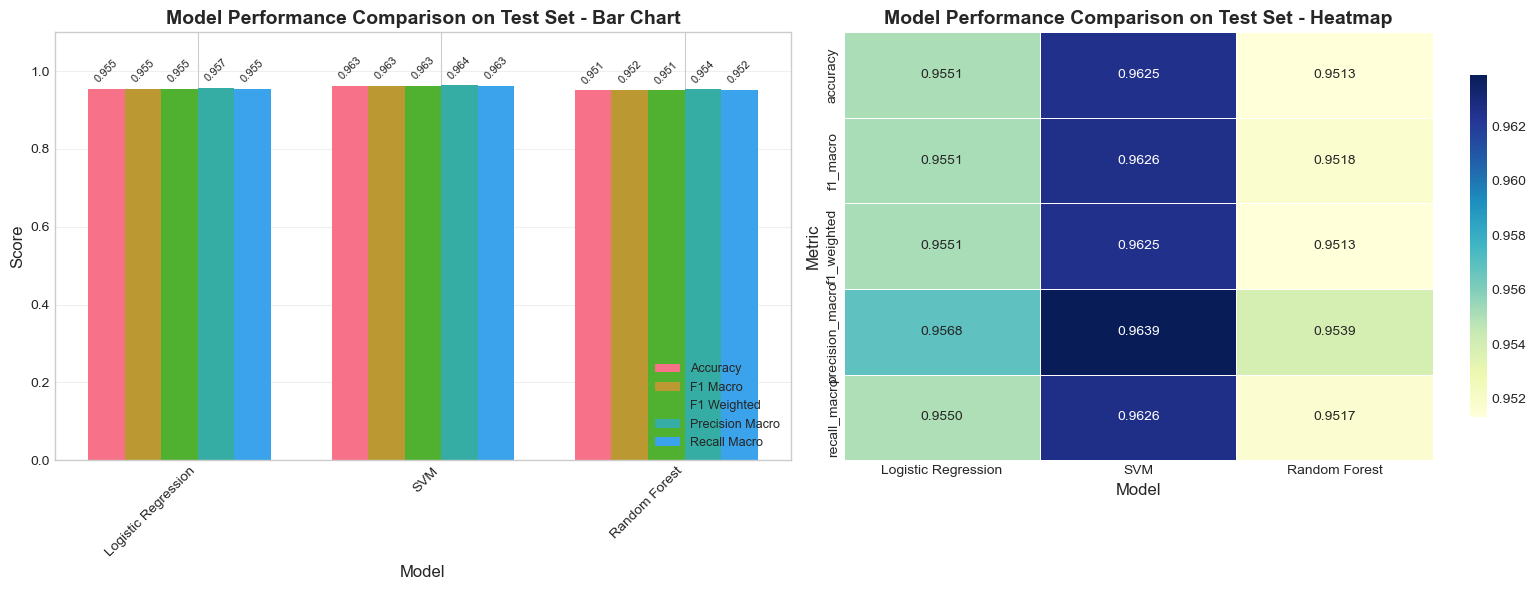

In [40]:
# Create comparison visualization
fig = plot_model_comparison(
    all_results,
    title="Model Performance Comparison on Test Set",
    figsize=(16, 6)
)
plt.show()

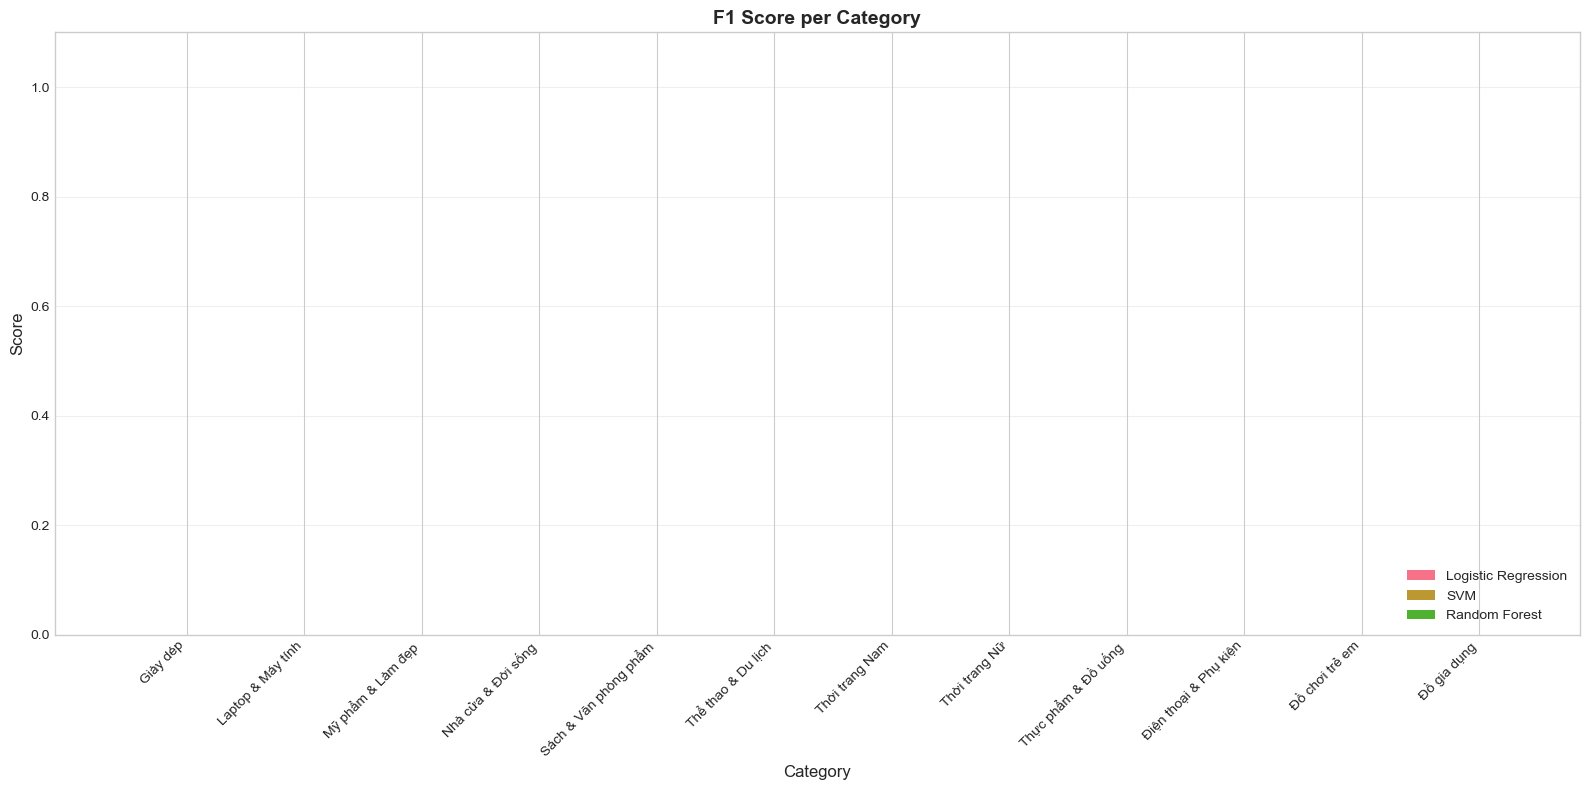

In [41]:
# Per-class F1 scores comparison
fig = plot_per_class_metrics(
    all_results,
    class_names,
    metric='f1_per_class',
    title="F1 Score per Category",
    figsize=(16, 8)
)
plt.show()

Best Model: SVM


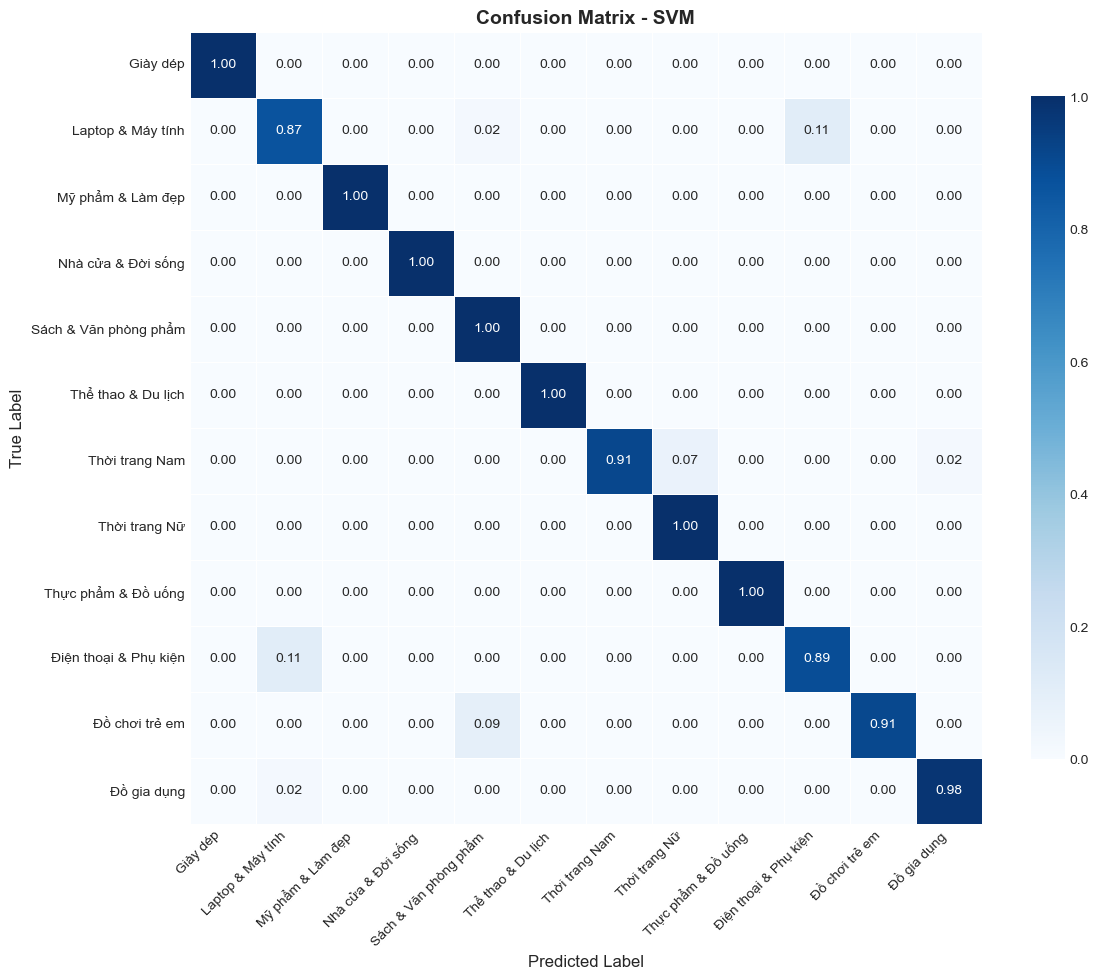

In [43]:
# Confusion matrix for best model
summary_df = create_results_summary(all_results, class_names)
best_model_name = summary_df.iloc[0]['Model']

print(f"Best Model: {best_model_name}")

fig = plot_confusion_matrix(
    all_results[best_model_name]['confusion_matrix'],
    class_names,
    title=f"Confusion Matrix - {best_model_name}",
    normalize=True
)
plt.show()

In [44]:
# # LSTM Training History
# if lstm_model.history:
#     fig = plot_training_history(
#         lstm_model.history.history,
#         title="LSTM Training History"
#     )
#     plt.show()

## 7. Final Report

In [45]:
# Print final report
print_final_report(all_results, class_names)


                        FINAL EVALUATION REPORT

📊 MODEL PERFORMANCE SUMMARY:
--------------------------------------------------------------------------------
              Model  Accuracy  F1 (Macro)  F1 (Weighted)  Precision (Macro)  Recall (Macro)
                SVM  0.962547    0.962570       0.962538           0.963889        0.962618
Logistic Regression  0.955056    0.955100       0.955115           0.956834        0.955039
      Random Forest  0.951311    0.951757       0.951347           0.953884        0.951680

--------------------------------------------------------------------------------
🏆 BEST MODEL: SVM
   F1 Score (Macro): 0.9626
   Accuracy: 0.9625

📈 PER-CLASS F1 SCORES (Best Model):
--------------------------------------------------------------------------------



In [46]:
# Save all visualizations
save_all_visualizations(all_results, class_names, VIS_DIR)

print(f"\n✅ All visualizations saved to {VIS_DIR}")

Comparison chart saved to /Users/leonnn/Downloads/NLP/visualizations/model_comparison.png
Per-class metrics chart saved to /Users/leonnn/Downloads/NLP/visualizations/f1_per_class.png
Confusion matrix saved to /Users/leonnn/Downloads/NLP/visualizations/confusion_matrix_logistic_regression.png
Confusion matrix saved to /Users/leonnn/Downloads/NLP/visualizations/confusion_matrix_svm.png
Confusion matrix saved to /Users/leonnn/Downloads/NLP/visualizations/confusion_matrix_random_forest.png

Results summary saved to /Users/leonnn/Downloads/NLP/visualizations/results_summary.csv

All visualizations saved to /Users/leonnn/Downloads/NLP/visualizations

✅ All visualizations saved to /Users/leonnn/Downloads/NLP/visualizations


## 8. Summary Table

In [47]:
# Display summary table with styling
summary_df = create_results_summary(all_results, class_names)

# Style the dataframe
styled_df = summary_df.style.background_gradient(
    subset=['Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'Precision (Macro)', 'Recall (Macro)'],
    cmap='YlGnBu'
).format({
    'Accuracy': '{:.4f}',
    'F1 (Macro)': '{:.4f}',
    'F1 (Weighted)': '{:.4f}',
    'Precision (Macro)': '{:.4f}',
    'Recall (Macro)': '{:.4f}'
}).set_caption("Model Performance Summary (Sorted by F1 Macro)")

styled_df

,Model,Accuracy,F1 (Macro),F1 (Weighted),Precision (Macro),Recall (Macro)
0,SVM,0.9625,0.9626,0.9625,0.9639,0.9626
1,Logistic Regression,0.9551,0.9551,0.9551,0.9568,0.9550
2,Random Forest,0.9513,0.9518,0.9513,0.9539,0.9517


## 9. Test Prediction với Sample Data

In [48]:
def predict_category(text, model_name='svm'):
    """Dự đoán danh mục cho văn bản mới"""
    from src.preprocessing import create_preprocessor
    from src.feature_extraction import load_vectorizer
    from src.ml_models import load_ml_model
    from src.data_utils import load_label_encoder
    
    # Preprocess
    preprocessor = create_preprocessor(use_word_segmentation=False, remove_stopwords=True)
    processed_text = preprocessor.preprocess(text)
    
    # Vectorize
    vec = load_vectorizer()
    X = vec.transform([processed_text])
    
    # Load model and predict
    model = load_ml_model(model_name)
    prediction = model.predict(X)[0]
    probas = model.predict_proba(X)[0]
    
    # Get label name
    encoder = load_label_encoder()
    category = encoder.inverse_transform([prediction])[0]
    
    # Top 3 predictions
    top_indices = probas.argsort()[-3:][::-1]
    top_categories = [(encoder.classes_[i], probas[i]) for i in top_indices]
    
    return {
        'predicted_category': category,
        'confidence': probas[prediction],
        'top_3': top_categories
    }

# Test predictions
test_samples = [
    "Áo dài truyền thống màu đỏ thêu hoa, chất liệu lụa cao cấp, form dáng chuẩn",
    "Điện thoại Samsung Galaxy S24 Ultra, chip Snapdragon mới nhất, camera 200MP",
    "Laptop gaming ASUS ROG, RTX 4090, màn hình 144Hz, RAM 32GB",
    "Son môi MAC chính hãng, màu đỏ cherry, lâu trôi cả ngày",
    "Nồi chiên không dầu Philips, dung tích 6L, công nghệ RapidAir"
]

print("\nPREDICTION DEMO\n" + "="*60)
for text in test_samples:
    result = predict_category(text, 'svm')
    print(f"\nInput: {text[:80]}...")
    print(f"Predicted: {result['predicted_category']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"   Top 3: {', '.join([f'{cat} ({prob:.2%})' for cat, prob in result['top_3']])}")


PREDICTION DEMO
Vectorizer loaded from /Users/leonnn/Downloads/NLP/models/tfidf_vectorizer.pkl
Model loaded from /Users/leonnn/Downloads/NLP/models/ml/svm.pkl

Input: Áo dài truyền thống màu đỏ thêu hoa, chất liệu lụa cao cấp, form dáng chuẩn...
Predicted: Thời trang Nữ
Confidence: 82.08%
   Top 3: Thời trang Nữ (82.08%), Đồ chơi trẻ em (4.39%), Thực phẩm & Đồ uống (2.69%)
Vectorizer loaded from /Users/leonnn/Downloads/NLP/models/tfidf_vectorizer.pkl
Model loaded from /Users/leonnn/Downloads/NLP/models/ml/svm.pkl

Input: Điện thoại Samsung Galaxy S24 Ultra, chip Snapdragon mới nhất, camera 200MP...
Predicted: Điện thoại & Phụ kiện
Confidence: 21.01%
   Top 3: Đồ chơi trẻ em (24.27%), Điện thoại & Phụ kiện (21.01%), Thể thao & Du lịch (14.30%)
Vectorizer loaded from /Users/leonnn/Downloads/NLP/models/tfidf_vectorizer.pkl
Model loaded from /Users/leonnn/Downloads/NLP/models/ml/svm.pkl

Input: Laptop gaming ASUS ROG, RTX 4090, màn hình 144Hz, RAM 32GB...
Predicted: Laptop & Máy tính
Conf